# Predicting Terrorist Attacks
## Weapon Classification

**Author:** Thomas Skowronek

**Date:** April 04, 2018

### Notebook Configuration

In [42]:
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [43]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### Load the Datasets
Load the dataset created by the EDA notebook.

In [44]:
# Load the preprocessed GTD dataset
gtd_df = pd.read_csv('../data/gtd_eda_95t016.csv', low_memory=False, index_col = 0,
                      na_values=[''])

### Inspect the Structure
The cleansed data frame contains 48 attributes, one of which is used for the data frame index, and 110,844 observations.

In [45]:
# Display a summary of the data frame
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null object
region_txt          110844 non-null object
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null float64
summary             110844 non-null object
attacktype1_txt     110844 non-null object
targtype1_txt       110844 non-null object
targsubtype1_txt    110844 non-null object
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null object
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null object
weapsubtype

### Convert Attributes to Correct Data Type
Convert a subset of the data frame attributes to categorical to align with the GTD code book as executed previously in the EDA notebook.

In [46]:
# List of attributes that are categorical
cat_attrs = ['extended_txt', 'country_txt', 'region_txt', 'specificity', 'vicinity_txt',
             'crit1_txt', 'crit2_txt', 'crit3_txt', 'doubtterr_txt', 'multiple_txt',
             'success_txt', 'suicide_txt', 'attacktype1_txt', 'targtype1_txt', 
             'targsubtype1_txt', 'natlty1_txt', 'guncertain1_txt', 'individual_txt', 
             'claimed_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'property_txt', 
             'ishostkid_txt', 'INT_LOG_txt', 'INT_IDEO_txt','INT_MISC_txt', 'INT_ANY_txt']

for cat in cat_attrs:
    gtd_df[cat] = gtd_df[cat].astype('category')
    

# Data time feature added during EDA
gtd_df['incident_date'] = pd.to_datetime(gtd_df['incident_date'])

# To prevent a mixed data type
gtd_df['gname'] = gtd_df['gname'].astype('str')

gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null category
region_txt          110844 non-null category
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null category
summary             110844 non-null object
attacktype1_txt     110844 non-null category
targtype1_txt       110844 non-null category
targsubtype1_txt    110844 non-null category
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null category
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null categ

### Create Training and Testing Datasets
The original dataset is split into 80% training and 20% testing.

In [47]:
# Seed for reproducible results
seed = 1009

# Predictor variables with one hot encoding
X = pd.get_dummies(gtd_df[['country_txt', 'region_txt', 'attacktype1_txt', 'nkill']], 
                   drop_first = True)

# Labels
y = gtd_df['weaptype1_txt']

# Create an 80/20 split for training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, stratify = y)

### KNN Classifier
Create a KNN classifier using 12 neighbors.

In [48]:
start = time.time()

# Create the classifier
knn1 = KNeighborsClassifier(n_neighbors = 12)
print("The KNN classifier parameter:\n")
print(knn1)

# Fit it using the training data
knn1.fit(X_train, y_train)

# Predict the lables using the test dataset
pred_lables1 = knn1.predict(X_test)

# Display a sample of the predictions
print("\nTest set predictions:\n {}".format(pred_lables1))

# Calculate the accuracy
score1 = accuracy_score(y_test, pred_lables1)
print("\nAccuracy: {}".format(score1))

end = time.time()
print("\nExecution Seconds: {}".format((end - start)))

The KNN classifier parameter:

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

Test set predictions:
 ['Unknown' 'Explosives/Bombs/Dynamite' 'Explosives/Bombs/Dynamite' ...,
 'Firearms' 'Explosives/Bombs/Dynamite' 'Firearms']

Accuracy: 0.884388109522306

Execution Seconds: 175.0124499797821


### Find the Best K
Iterate from 1 to 12 to find the best value for K.

In [49]:
start = time.time()

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 12)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn2 = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn2.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn2.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn2.score(X_test, y_test)


end = time.time()
print("Execution Seconds: {}".format((end - start)))

Execution Seconds: 8970.889966964722


### Compare the Training and Testing Scores
Plot each of the training and testing scores.

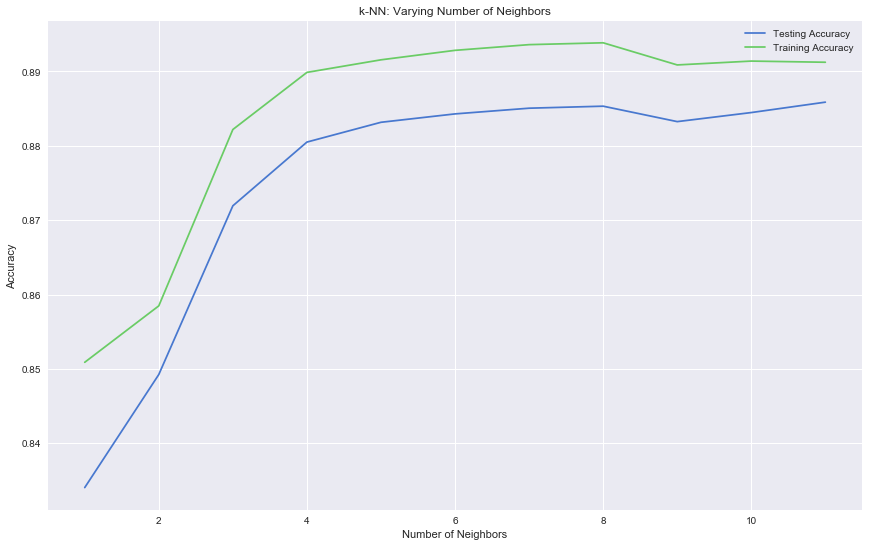

In [50]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### KNN Classifier
Create a KNN classifier using best K of 11 neighbors from the previous test.

In [52]:
start = time.time()

# Create the classifier
knn3 = KNeighborsClassifier(n_neighbors = 11)
print("The KNN classifier parameter:\n")
print(knn3)

# Fit it using the training data
knn3.fit(X_train, y_train)

# Predict the lables using the test dataset
pred_lables3 = knn3.predict(X_test)

# Calculate the accuracy
score3 = accuracy_score(y_test, pred_lables3)
print("\nAccuracy: {}".format(score3))

end = time.time()
print("\nExecution Seconds: {}".format((end - start)))

The KNN classifier parameter:

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

Accuracy: 0.8858766746357526

Execution Seconds: 177.72135090827942


### References

Bowne-Anderson, H. (n.d.). Measuring model performance Retrieved from https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/classification?ex=9